In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Lib Imports

In [2]:
pip install numdifftools optuna imblearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.2/100.2 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.0/247.0 kB 20.4 MB/s eta 0:00:00


In [367]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from torch.autograd import grad as torch_grad
import torch.nn.functional as F
from torch.autograd import Variable

import xgboost as xgb

from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from scipy.interpolate import interp1d
from scipy.differentiate import derivative
import numdifftools as nd
from scipy.signal import argrelextrema
from sklearn.ensemble import AdaBoostClassifier
from imblearn.over_sampling import ADASYN

# Data Import

In [368]:
df=pd.read_csv("/content/drive/MyDrive/tft/data/new/df_with_trends_5m.csv")
df.head()

,timestamp,pca1,pca2,pca3,pca4,pca5,pca6,pca7,pca8,pca11,...,pca17,pca18,pca19,pca20,pca21,close,Bitcoin,Bitcoin price,Bitcoin dip,Buy Bitcoin
0,2023-05-01 18:25:00,-4.728668,-1.114607,-0.365115,0.485136,0.384824,1.576102,1.213044,0.924503,0.821012,...,0.312060,1.402576,1.568977,0.565268,0.149354,28212.73,71.75,81.166667,0.0,80.333333
1,2023-05-01 18:30:00,-4.634006,-2.731459,1.695327,-2.316193,-0.782514,0.937458,1.450889,0.243998,-1.020911,...,0.060306,1.301197,1.825314,-0.126535,0.037677,28127.82,72.50,82.000000,0.0,81.000000
2,2023-05-01 18:35:00,-4.696686,-1.201332,0.447267,1.522653,0.018328,0.077646,-1.386036,-1.748878,0.032070,...,0.696833,1.348496,1.671811,0.304412,0.202355,28169.00,73.25,82.833333,0.0,81.666667
3,2023-05-01 18:40:00,-4.711780,-2.333551,0.040513,-0.850880,0.054831,-1.126004,2.241217,-1.532337,-0.500323,...,0.286385,1.370392,1.611524,0.443190,0.128267,28128.59,74.00,83.666667,0.0,82.333333
4,2023-05-01 18:45:00,-4.715642,-1.501571,0.141052,1.013131,0.073797,1.087630,0.091214,-0.375504,0.322662,...,0.552559,1.358777,1.638289,0.411483,0.193431,28150.00,74.75,84.500000,0.0,83.000000


In [369]:
print(df.shape)

(210485, 23)


In [370]:
def NaNCheck(data):
  return data.isnull().sum()[data.isnull().sum()>0]

print(NaNCheck(df))

Series([], dtype: int64)


# Data Preprocess

### Sliding Window Function

In [371]:
def sliding_window(x, y, y_raw ,feature_window,label_window,trend_window):
    x_ = []
    y_ = []
    y_gan_pr = []
    y_gan_cl = []
    y_gan_tr = []
    backward_length = max(trend_window,label_window)
    for i in range(backward_length, x.shape[0]-label_window):
        tmp_x = x[i - feature_window: i, :]
        tmp_y = y[i]
        tmp_y_gan_pr = y[i - feature_window: i + 1]
        tmp_y_gan_cl = y_raw[i - label_window: i + label_window+1]
        tmp_y_gan_tr = y_raw[i - trend_window: i, :]
        x_.append(tmp_x)
        y_.append(tmp_y)
        y_gan_pr.append(tmp_y_gan_pr)
        y_gan_cl.append(tmp_y_gan_cl)
        y_gan_tr.append(tmp_y_gan_tr)
    x_ = torch.from_numpy(np.array(x_)).float()
    y_ = torch.from_numpy(np.array(y_)).float()
    y_gan_pr = torch.from_numpy(np.array(y_gan_pr)).float()
    y_gan_cl = torch.from_numpy(np.array(y_gan_cl)).float()
    y_gan_tr = torch.from_numpy(np.array(y_gan_tr)).float()
    return x_, y_, y_gan_pr,y_gan_cl,y_gan_tr


### Trend Ditection Component

In [372]:
def trend_detection(data):
    n = data.shape[1]
    sets = data.shape[0]
    mean_derivatives = np.zeros((sets,1))

    data = data.numpy()

    for i in range(sets):
        # Select the i-th 20 set
        x = np.arange(1,n+1)
        x_fake = np.arange(1.1, n, 0.1)
        y = data[i, :, 0]
        # Simple interpolation of x and y
        f = interp1d(x, y)

        # derivative of y with respect to x
        df_dx = nd.Derivative(f, step=1e-6)(x_fake)
        # Calculate the mean derivative for the i-th 20 set
        average = np.average(df_dx)
        mean_derivatives[i][0] = average
    return  torch.from_numpy(mean_derivatives)

### Constants

In [373]:
training_duration = 4032
validation_duration = 864
testing_duration = 8640
train_offset = 8640*4+4032
smoothing_threshold = 50
sliding_window_size = 10
classification_label_size = 12
trend_measure_lenth = 12

### Train test split

In [374]:
labels_df = df["close"]
features_df = df.drop(columns=["close", "Bitcoin", "Bitcoin price", "Bitcoin dip", "Buy Bitcoin", "timestamp"])

st_train = train_offset
train_x = features_df.iloc[st_train:st_train+training_duration]
train_y = labels_df.iloc[st_train:st_train+training_duration]

# st_test = training_duration+validation_duration+st_train
st_test = 864
test_x = features_df.iloc[st_test:st_test+testing_duration]
test_y = labels_df.iloc[st_test:st_test+testing_duration]

print(f'trainX: {train_x.shape} trainY: {train_y.shape}')
print(f'testX: {test_x.shape} testY: {test_y.shape}')


trainX: (4032, 17) trainY: (4032,)
testX: (8640, 17) testY: (8640,)


### Scalling

In [375]:
x_scaler = MinMaxScaler(feature_range = (0, 1))
y_scaler = MinMaxScaler(feature_range = (0, 1))
trend_scaler = MinMaxScaler(feature_range = (0, 1))

train_x = x_scaler.fit_transform(train_x)
test_x = x_scaler.transform(test_x)

raw_train_y = train_y.values.reshape(-1, 1)
raw_test_y = test_y.values.reshape(-1, 1)
train_y = y_scaler.fit_transform(train_y.values.reshape(-1, 1))
test_y = y_scaler.transform(test_y.values.reshape(-1, 1))

### Dataset preparation for models

In [376]:
# For price prediction model
train_x_slide, train_y_slide, train_y_gan,train_y_gan_cl,train_direction_slide = sliding_window(train_x, train_y,raw_train_y, sliding_window_size,classification_label_size,trend_measure_lenth)
test_x_slide, test_y_slide, test_y_gan,test_y_gan_cl,test_direction_slide = sliding_window(test_x, test_y, raw_test_y ,sliding_window_size,classification_label_size,trend_measure_lenth)

train_trend_features = trend_detection(train_direction_slide)
test_trend_features = trend_detection(test_direction_slide)
train_trend_features = torch.tensor(trend_scaler.fit_transform(train_trend_features))
test_trend_features = torch.tensor(trend_scaler.transform(test_trend_features))
new_feature_tensor_train = train_trend_features.repeat(1,10)
new_feature_tensor_train = new_feature_tensor_train.unsqueeze(2)
new_feature_tensor_test = test_trend_features.repeat(1,10)
new_feature_tensor_test = new_feature_tensor_test.unsqueeze(2)

print('For Price prediction')
print(f'train_x_slide: {train_x_slide.shape} train_y_slide: {train_y_slide.shape} train_y_gan: {train_y_gan.shape}')
print(f'test_x_slide: {test_x_slide.shape} test_y_slide: {test_y_slide.shape} test_y_gan: {test_y_gan.shape}\n')

print('For Bottom classification')
print(f'train_x_slide: {train_x_slide.shape} train_y_gan_cl: {train_y_gan_cl.shape}')
print(f'test_x_slide: {test_x_slide.shape} test_y_gan_cl: {test_y_gan_cl.shape}\n')

print('For current trend calculation')
print(f'train_direction_slide: {train_direction_slide.shape} train_trend_features: {train_trend_features.shape} ')
print(f'test_direction_slide: {test_direction_slide.shape} test_trend_features: {test_trend_features.shape} ')

For Price prediction
train_x_slide: torch.Size([4008, 10, 17]) train_y_slide: torch.Size([4008, 1]) train_y_gan: torch.Size([4008, 11, 1])
test_x_slide: torch.Size([8616, 10, 17]) test_y_slide: torch.Size([8616, 1]) test_y_gan: torch.Size([8616, 11, 1])

For Bottom classification
train_x_slide: torch.Size([4008, 10, 17]) train_y_gan_cl: torch.Size([4008, 25, 1])
test_x_slide: torch.Size([8616, 10, 17]) test_y_gan_cl: torch.Size([8616, 25, 1])

For current trend calculation
train_direction_slide: torch.Size([4008, 12, 1]) train_trend_features: torch.Size([4008, 1]) 
test_direction_slide: torch.Size([8616, 12, 1]) test_trend_features: torch.Size([8616, 1]) 


# Model Implementation

## GAN Model

#### Generator

In [377]:
class Generator(nn.Module):

    def __init__(self, input_size):
        super().__init__()

        # 3 GRU layers, input_size = features
        self.gru_1 = nn.GRU(input_size, 1024, batch_first=True)
        self.gru_2 = nn.GRU(1024, 512, batch_first = True)
        self.gru_3 = nn.GRU(512, 256, batch_first = True)
        # 3 Dense Layers
        self.linear_1 = nn.Linear(256, 128)
        self.linear_2 = nn.Linear(128, 64)
        self.linear_3 = nn.Linear(64, 1)

        self.dropout = nn.Dropout(0.2)
        self.tanh = nn.Tanh()


    def forward(self, x,use_cuda=1):
        device = torch.device("cuda" if (torch.cuda.is_available() & use_cuda) else "cpu")
        h0 = torch.zeros(1, x.size(0), 1024).to(device) # initial hidden state for the 1st GRU Layer - (num of layers in the GRU, batch size, num of hidden units in the GRU)
        out_gru_1, _ = self.gru_1(x, h0)
        out_gru_1 = self.dropout(out_gru_1)

        h1 = torch.zeros(1, x.size(0), 512).to(device)
        out_gru_2, _ = self.gru_2(out_gru_1, h1)
        out_gru_2 = self.dropout(out_gru_2)

        h2 = torch.zeros(1, x.size(0), 256).to(device)
        out_gru_3, _ = self.gru_3(out_gru_2, h2)
        out_gru_3 = self.dropout(out_gru_3)

        out_dense_1 = self.linear_1(out_gru_3[:, -1, :])
        out_dense_2 = self.linear_2(out_dense_1)
        out_dense_3 = self.linear_3(out_dense_2)

        return out_dense_3,out_gru_3

#### Discriminator

In [378]:
class Discriminator(nn.Module):
  def __init__(self):
    super().__init__()

    # 3 1D Conv layers
    self.conv1 = nn.Conv1d(sliding_window_size+1, 32, kernel_size = 5, stride = 1, padding = 'same')
    self.conv2 = nn.Conv1d(32, 64, kernel_size = 5, stride = 1, padding = 'same')
    self.conv3 = nn.Conv1d(64, 128, kernel_size = 5, stride = 1, padding = 'same')

    # 3 linear layers
    self.linear1 = nn.Linear(128, 220)
    self.linear2 = nn.Linear(220, 220)
    self.linear3 = nn.Linear(220, 1)

    self.leaky = nn.LeakyReLU(0.01)
    self.relu = nn.ReLU()
    self.tanh = nn.Tanh()

  def forward(self, x):
    conv1 = self.conv1(x)
    conv1 = self.leaky(conv1)
    conv2 = self.conv2(conv1)
    conv2 = self.leaky(conv2)
    conv3 = self.conv3(conv2)
    conv3 = self.leaky(conv3)

    flatten_x =  conv3.reshape(conv3.shape[0], conv3.shape[1])

    out_1 = self.linear1(flatten_x)
    out_1 = self.leaky(out_1)
    out_2 = self.linear2(out_1)
    out_2 = self.relu(out_2)
    out_3 = self.linear3(out_2)

    return out_3

#### Gradient Panelty

In [379]:
def grad_penalty_fnc(real_data, gen_data,D,cuda,gp_weight):
    batch_size = real_data.size()[0]
    t = torch.rand((batch_size, 1, 1), requires_grad=True)
    t = t.expand_as(real_data)

    if cuda:
        t = t.cuda()

    # mixed sample from real and fake; make approx of the 'true' gradient norm
    interpol = t * real_data.data + (1-t) * gen_data.data

    if cuda:
        interpol = interpol.cuda()
    prob_interpol = D(interpol)
    torch.autograd.set_detect_anomaly(True)
    gradients = torch_grad(outputs=prob_interpol, inputs=interpol,
                           grad_outputs=torch.ones(prob_interpol.size()).cuda() if cuda else torch.ones(
                               prob_interpol.size()), create_graph=True, retain_graph=True)[0]
    gradients = gradients.view(batch_size, -1)
    #grad_norm = torch.norm(gradients, dim=1).mean()
    #self.losses['gradient_norm'].append(grad_norm.item())

    # add epsilon for stability
    eps = 1e-10
    gradients_norm = torch.sqrt(torch.sum(gradients**2, dim=1, dtype=torch.double) + eps)
    #gradients = gradients.cpu()
    # comment: precision is lower than grad_norm (think that is double) and gradients_norm is float
    final = gp_weight * (torch.max(torch.zeros(1,dtype=torch.double).cuda() if cuda else torch.zeros(1,dtype=torch.double), gradients_norm.mean() - 1) ** 2), gradients_norm.mean().item()
    return final


## Bottom Point Classification Model

### Bottom Point Labeling

In [380]:
def find_bottom_point_labels_mean(y,slide):

    y1 = y[:, :slide, :] # 128,10,1
    y2 = y[:, slide+1:, :]
    values = y[:,slide,:]

    y_avg = torch.mean(y1,dim=1)
    y_next_avg = torch.mean(y2, dim=1)
    y_bool = y_avg>(y[:,slide,:] + smoothing_threshold)
    y_next_bool = y_next_avg>(y[:,slide,:] + smoothing_threshold)
    result = np.logical_and(y_bool.numpy(), y_next_bool.numpy())
    y_label=np.where(result, 1, 0)

    index_val = np.where(y_label == 1)
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    plt.figure(figsize=(15, 8))
    plt.plot(y[:,slide,:], zorder=0)
    plt.scatter(index_val[0], values[np.where(y_label == 1)],
      label='Minima', s=100, color=colors[1], marker='^')
    plt.legend()
    plt.show()

    y_labels = torch.from_numpy(y_label)

    return y_labels

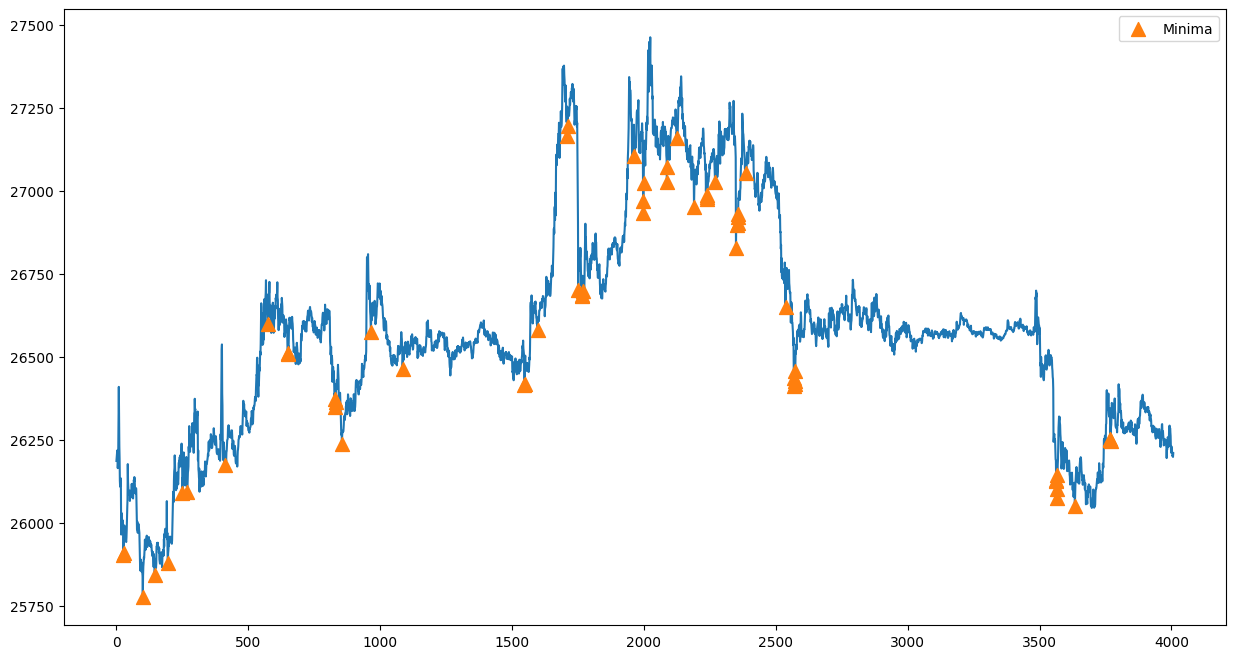

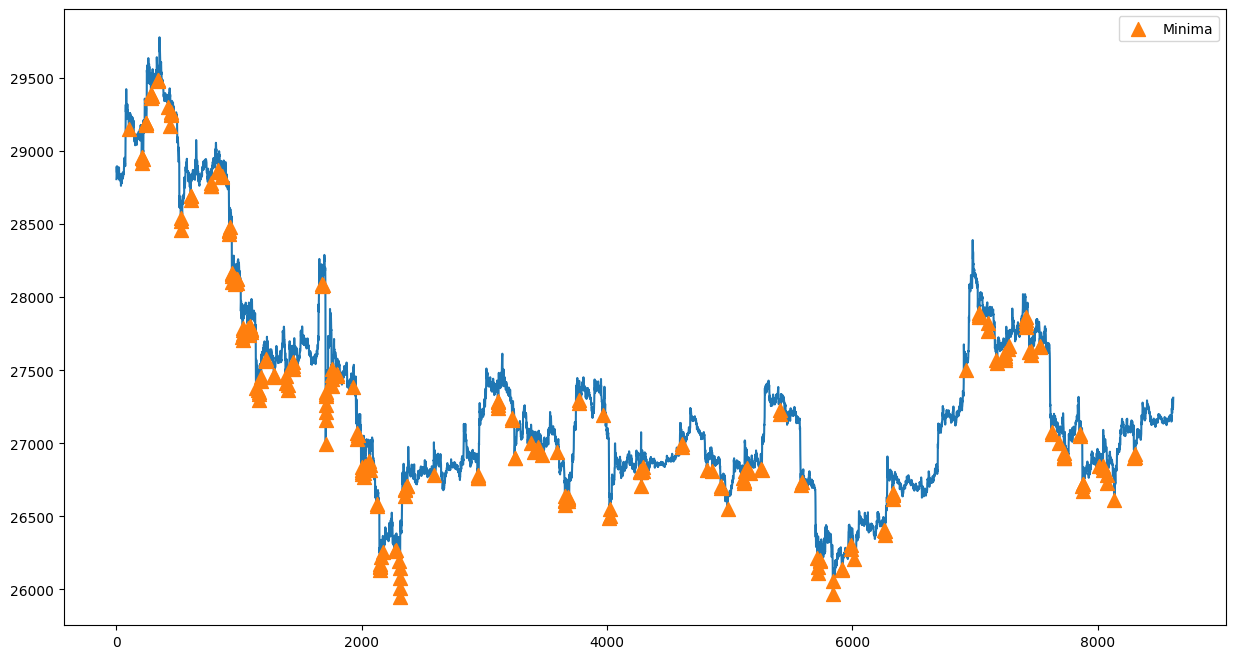

[3949   59]
[8361  255]
66.9322033898305


In [381]:
def calc_labels(labels):
    unique_labels = torch.unique(labels)
    unique_labels, label_counts = np.unique(labels.numpy(), return_counts=True)
    return label_counts

train_bottoms = find_bottom_point_labels_mean(train_y_gan_cl,classification_label_size)
test_bottoms = find_bottom_point_labels_mean(test_y_gan_cl,classification_label_size)
train_bottom_count = calc_labels(train_bottoms)
test_bottom_count = calc_labels(test_bottoms)
print(train_bottom_count)
print(test_bottom_count)
print(train_bottom_count[0]/train_bottom_count[1])

### Bottom Point Implementation - XGBoost

In [382]:
spw = train_bottom_count[0]/train_bottom_count[1]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def xgboost_train(x,y,eta=0.1):
    x = x.reshape(x.shape[0], -1)
    adasyn = ADASYN(sampling_strategy=0.3, random_state=42)
    x, y = adasyn.fit_resample(x.detach().cpu().numpy(), y.detach().cpu().numpy())
    model= xgb.XGBClassifier(
        n_estimators=700,
        max_depth=7,
        learning_rate=0.1,
        objective='binary:logistic',
        eval_metric='aucpr',
        subsample = 0.1,
        colsample_bytree = 0.15,
        min_child_weight= 15,
        reg_alpha=0.7,
    )
    model.fit(x,y)
    return model

def xgboost_test(x, y,xgmodel):
    out_gru_3_xg = x.reshape(x.shape[0], -1)
    pred = xgmodel.predict(out_gru_3_xg.detach().cpu().numpy())
    pred = torch.tensor(pred).reshape(pred.shape[0],1)
    return pred,y

In [383]:
import numpy as np
import torch
import logging
from sklearn.model_selection import train_test_split
from sklearn.metrics import average_precision_score
import xgboost as xgb

try:
    import optuna
except ImportError:
    optuna = None

def xgboost_train_weighted(
        x: torch.Tensor,
        y: torch.Tensor,
        random_state: int = 42,
        use_optuna: bool = True,
        n_optuna_trials: int = 40,
        gpu: bool = True,
        multi_gpu: bool = False,
        early_stopping_rounds: int = 50,
        base_n_estimators: int = 1200,
        min_delta: float = 0.0,   # kept for API symmetry; not used by constructor ES
        log_level: int = logging.INFO,
        verbose_model: int = 0
    ):
    """
    Train an XGBoost model with class weighting (scale_pos_weight), optional Optuna tuning,
    and constructor-based early stopping (robust against callback best_iteration bug).
    Returns (model, best_params_dict).
    """

    logging.basicConfig(level=log_level, format='[%(asctime)s] %(levelname)s: %(message)s')
    logger = logging.getLogger("xgb_train")

    logger.info("Starting weighted XGBoost training (constructor early stopping).")

    # -------- Data --------
    X = x.reshape(x.shape[0], -1).detach().cpu().numpy()
    Y = y.detach().cpu().numpy()

    # Stratified split to preserve minority class in validation
    X_train, X_valid, y_train, y_valid = train_test_split(
        X, Y, test_size=0.2, stratify=Y, random_state=random_state
    )

    # Check validation contains both classes
    if len(np.unique(y_valid)) < 2:
        raise ValueError("Validation set has only one class; adjust split or use larger dataset for early stopping.")

    n_pos = (y_train == 1).sum()
    n_neg = (y_train == 0).sum()
    scale_pos_weight = n_neg / max(1, n_pos)
    logger.info(f"Train class distribution: pos={n_pos}, neg={n_neg}, scale_pos_weight={scale_pos_weight:.3f}")

    tree_method = 'gpu_hist' if gpu else 'hist'
    params_base = dict(
        objective='binary:logistic',
        eval_metric='aucpr',
        tree_method=tree_method,
        random_state=random_state,
        scale_pos_weight=scale_pos_weight,
        verbosity=verbose_model,
        early_stopping_rounds=early_stopping_rounds
    )
    if gpu and multi_gpu:
        params_base["n_gpus"] = -1
        logger.info("Multi-GPU enabled (n_gpus=-1).")

    default_space = dict(
        max_depth=6,
        min_child_weight=5,
        learning_rate=0.03,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_alpha=0.1,
        reg_lambda=2.0,
        gamma=0.0,
        n_estimators=base_n_estimators
    )

    def fit_and_score(model_params, label="model"):
        clf = xgb.XGBClassifier(**model_params)
        clf.fit(
            X_train, y_train,
            eval_set=[(X_valid, y_valid)],
            verbose=False
        )
        y_pred = clf.predict_proba(X_valid)[:, 1]
        ap = average_precision_score(y_valid, y_pred)

        # Safe best_iteration extraction (may not exist if no early stop triggered)
        if hasattr(clf, "best_iteration"):
            best_iter = int(clf.best_iteration)
            stopped_early = True
        else:
            best_iter = clf.get_booster().num_boosted_rounds() - 1
            stopped_early = False
        logger.info(f"{label}: AP={ap:.5f} best_iter={best_iter} early_stopped={stopped_early}")
        return clf, ap, best_iter, stopped_early

    best_model = None
    best_params_report = {}
    best_score = -np.inf

    if use_optuna and optuna is not None:
        logger.info(f"Optuna search: {n_optuna_trials} trials.")

        def objective(trial):
            trial_params = {
                "max_depth": trial.suggest_int("max_depth", 3, 9),
                "min_child_weight": trial.suggest_int("min_child_weight", 1, 15),
                "learning_rate": trial.suggest_float("learning_rate", 0.005, 0.2, log=True),
                "subsample": trial.suggest_float("subsample", 0.5, 1.0),
                "colsample_bytree": trial.suggest_float("colsample_bytree", 0.4, 1.0),
                "reg_alpha": trial.suggest_float("reg_alpha", 1e-3, 5.0, log=True),
                "reg_lambda": trial.suggest_float("reg_lambda", 0.5, 10.0, log=True),
                "gamma": trial.suggest_float("gamma", 0.0, 3.0),
                "n_estimators": trial.suggest_int("n_estimators", 400, 1800)
            }
            params = {**params_base, **trial_params}
            clf, ap, best_iter, stopped = fit_and_score(params, label=f"trial {trial.number}")
            trial.set_user_attr("best_iteration", best_iter)
            trial.set_user_attr("early_stopped", stopped)
            return ap

        study = optuna.create_study(direction="maximize")
        study.optimize(objective, n_trials=n_optuna_trials, show_progress_bar=False)
        logger.info(f"Optuna best trial {study.best_trial.number} AP={study.best_value:.5f}")

        refit_params = {**params_base, **study.best_trial.params}
        best_model, best_score, best_iter, stopped = fit_and_score(refit_params, label="refit best")

        best_params_report = {
            **refit_params,
            "scale_pos_weight": scale_pos_weight,
            "best_iteration": best_iter,
            "early_stopped": stopped,
            "best_score_valid_aucpr": float(best_score),
            "optuna_best_trial": study.best_trial.number
        }
    else:
        if use_optuna and optuna is None:
            logging.warning("Optuna not installed; using default parameters.")
        base_params = {**params_base, **default_space}
        best_model, best_score, best_iter, stopped = fit_and_score(base_params, label="baseline")
        best_params_report = {
            **base_params,
            "scale_pos_weight": scale_pos_weight,
            "best_iteration": best_iter,
            "early_stopped": stopped,
            "best_score_valid_aucpr": float(best_score),
            "optuna_best_trial": None
        }

    logger.info(f"Done. Validation AP={best_score:.5f}; early_stopped={best_params_report['early_stopped']}")
    return best_model, best_params_report


### Test with pretrained GAN model

In [384]:
# learning_rate_xgboost2 = 0.3

modelG2 = Generator(train_x.shape[1]).to(device)
modelG2.load_state_dict(torch.load("/content/drive/MyDrive/tft/model-wgan-10-1/modelG_state.pt",map_location=torch.device('cpu')))
modelG2.eval()


# Run inference on GPU
with torch.no_grad():
    _, train_input_features = modelG2(train_x_slide.to(device))
    train_input_features = torch.cat(
        (train_input_features, new_feature_tensor_train.to(device)),
        dim=2
    )
# _,train_input_features = modelG2(train_x_slide.to(device))
# train_input_features = torch.cat((train_input_features, new_feature_tensor_train), dim=2)


# Move to CPU for post-processing
train_input_features = train_input_features.cpu()

xgb_model, best_params_report = xgboost_train_weighted(train_input_features,train_bottoms)

pred_direction_train,true_direction_train = xgboost_test(train_input_features,train_bottoms,xgb_model)
pred_direction_train = torch.round(pred_direction_train).long()
f1_score_val_train =  f1_score(train_bottoms.numpy(), pred_direction_train.numpy())
precision_score_val_train = precision_score(train_bottoms.numpy(), pred_direction_train.numpy(),zero_division=0)
recall_score_train = recall_score(train_bottoms.numpy(), pred_direction_train.numpy(), average='micro')

# Run inference on GPU
with torch.no_grad():
    _,test_input_features = modelG2(test_x_slide.to(device))
    test_input_features = torch.cat((test_input_features, new_feature_tensor_test.to(device)), dim=2)

test_input_features = test_input_features.cpu()
pred_direction_test,true_direction_test = xgboost_test(test_input_features,test_bottoms,xgb_model)
pred_direction_test = torch.round(pred_direction_test).long()
f1_score_val_test = f1_score(test_bottoms.numpy(), pred_direction_test.numpy())
precision_score_val_test = precision_score(test_bottoms.numpy(), pred_direction_test.numpy(),zero_division=0)
recall_score_test = recall_score(test_bottoms.numpy(), pred_direction_test.numpy(), average='micro')

print("F1_score_train:", f1_score_val_train)
print("Precision_train: ",precision_score_val_train)
print("Recall_train: ",recall_score_train)
print("F1_score_test:", f1_score_val_test)
print("Precision_test: ",precision_score_val_test)
print("Recall_test: ",recall_score_test)

[I 2025-07-29 17:26:50,660] A new study created in memory with name: no-name-92d81823-d7d4-4432-a68a-2fdebe325d6f
[I 2025-07-29 17:26:52,193] Trial 0 finished with value: 0.22897432543785937 and parameters: {'max_depth': 3, 'min_child_weight': 13, 'learning_rate': 0.1371379792649167, 'subsample': 0.6773924935243307, 'colsample_bytree': 0.44993725509265775, 'reg_alpha': 0.00486589244978913, 'reg_lambda': 6.669811145159607, 'gamma': 2.5599605890979165, 'n_estimators': 840}. Best is trial 0 with value: 0.22897432543785937.
[I 2025-07-29 17:26:54,140] Trial 1 finished with value: 0.32574147321487745 and parameters: {'max_depth': 6, 'min_child_weight': 15, 'learning_rate': 0.152210270378077, 'subsample': 0.7388900501283009, 'colsample_bytree': 0.48099212970018296, 'reg_alpha': 0.004773712586770432, 'reg_lambda': 2.8108411295414486, 'gamma': 2.534914821319862, 'n_estimators': 1775}. Best is trial 1 with value: 0.32574147321487745.
[I 2025-07-29 17:26:56,093] Trial 2 finished with value: 0.33

F1_score_train: 0.6459627329192547
Precision_train:  0.5098039215686274
Recall_train:  0.9857784431137725
F1_score_test: 0.28888888888888886
Precision_test:  0.20155038759689922
Recall_test:  0.9257195914577531


In [385]:
best_params_report

{'objective': 'binary:logistic',
 'eval_metric': 'aucpr',
 'tree_method': 'gpu_hist',
 'random_state': 42,
 'scale_pos_weight': np.float64(67.2127659574468),
 'verbosity': 0,
 'early_stopping_rounds': 50,
 'max_depth': 4,
 'min_child_weight': 14,
 'learning_rate': 0.08496182236145614,
 'subsample': 0.6720601130698735,
 'colsample_bytree': 0.9083472308660501,
 'reg_alpha': 0.8676215978169978,
 'reg_lambda': 0.8943970106528546,
 'gamma': 2.675852034483085,
 'n_estimators': 658,
 'best_iteration': 97,
 'early_stopped': True,
 'best_score_valid_aucpr': 0.37331308540458097,
 'optuna_best_trial': 33}

In [386]:
xgb_model.save_model("BPC_BTC.model")

/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:1028: UserWarning: [17:28:16] WARNING: /workspace/src/c_api/c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  self.get_booster().save_model(fname)


# Buy  Hold Strategy

### Get predictions

In [387]:
modelG = Generator(train_x.shape[1]).to(device)
modelG.load_state_dict(torch.load("/content/drive/MyDrive/tft/model-wgan-10-1/modelG_state.pt",map_location=torch.device('cpu')))
modelG.eval()
model_xgboost1 = xgb.XGBClassifier()
model_xgboost1.load_model("/content/BPC_BTC.model")

with torch.no_grad():
  _,test_input_features = modelG(test_x_slide.to(device))
  test_input_features = torch.cat((test_input_features, new_feature_tensor_test.to(device)), dim=2)
test_input_features = test_input_features.cpu()
pred_direction_test,true_direction_test = xgboost_test(test_input_features,test_bottoms,model_xgboost1)
pred_direction_test = torch.round(pred_direction_test).long()
f1_score_val_test = f1_score(test_bottoms.numpy(), pred_direction_test.numpy())
precision_score_val_test = precision_score(test_bottoms.numpy(), pred_direction_test.numpy(),zero_division=0)
recall_score_test = recall_score(test_bottoms.numpy(), pred_direction_test.numpy(), average='micro')


print("F1_score_test:", f1_score_val_test)
print("Precision_test: ",precision_score_val_test)
print("Recall_test: ",recall_score_test)

F1_score_test: 0.28888888888888886
Precision_test:  0.20155038759689922
Recall_test:  0.9257195914577531


In [388]:
predicted_bottom_count = calc_labels(pred_direction_test)
Actual_bottom_count = calc_labels(test_bottoms)
print("Predicted bottoms",predicted_bottom_count)
print("Actual bottoms",Actual_bottom_count)

Predicted bottoms [7971  645]
Actual bottoms [8361  255]


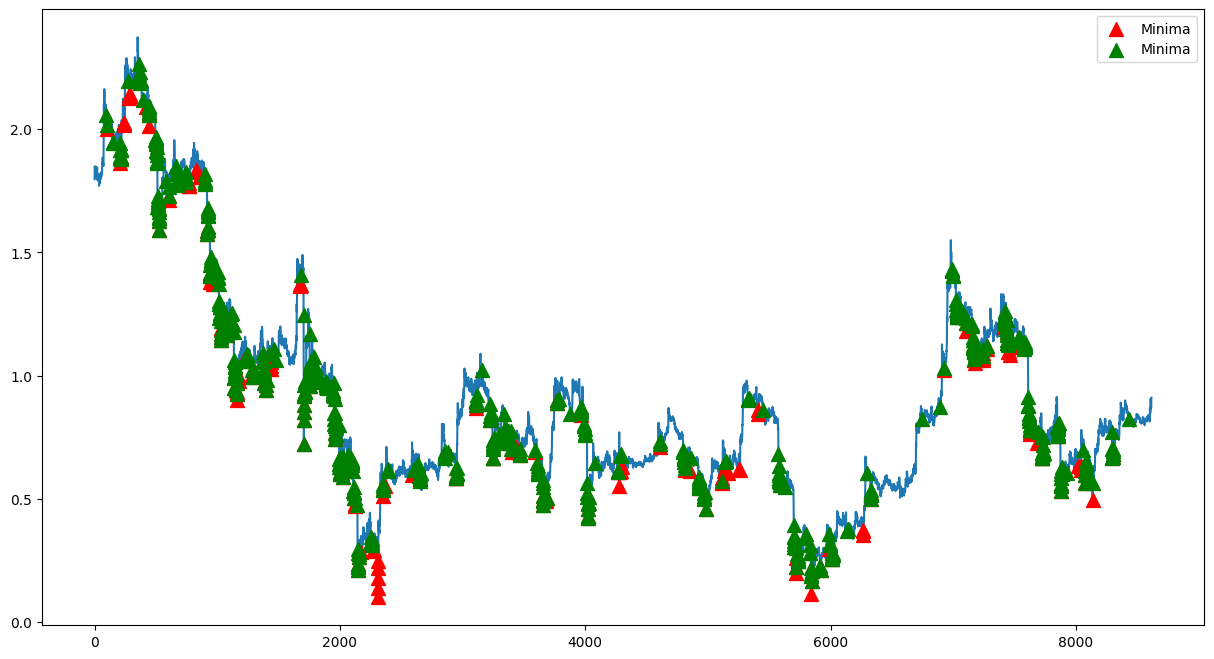

In [389]:
y_label=pred_direction_test
y_label_true = test_bottoms

index_val = np.where(y_label == 1)
index_val_true = np.where(y_label_true == 1)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.figure(figsize=(15, 8))
plt.plot(test_y_slide, zorder=0)
plt.scatter(index_val_true[0], test_y_slide[np.where(y_label_true == 1)],
  label='Minima', s=100, color='red', marker='^')
plt.scatter(index_val[0], test_y_slide[np.where(y_label == 1)],
  label='Minima', s=100, color='green', marker='^')
plt.legend()
plt.show()

In [390]:
predictions = torch.squeeze(pred_direction_test)
indices = torch.nonzero(predictions).flatten()
print(indices)

tensor([  92,  101,  148,  152,  207,  208,  209,  210,  211,  212,  213,  214,
         215,  216,  217,  272,  341,  342,  363,  366,  367,  370,  374,  376,
         391,  441,  442,  443,  444,  445,  446,  496,  497,  498,  499,  500,
         501,  502,  503,  504,  505,  506,  507,  508,  509,  511,  512,  513,
         514,  515,  516,  517,  518,  519,  520,  521,  522,  523,  524,  525,
         526,  527,  528,  529,  586,  606,  607,  662,  663,  665,  670,  674,
         675,  743,  744,  745,  746,  899,  900,  902,  903,  919,  920,  921,
         922,  923,  924,  925,  926,  927,  928,  942,  943,  944,  945,  946,
         947,  948,  949,  950,  952,  966, 1002, 1003, 1004, 1007, 1009, 1011,
        1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1023, 1025, 1027, 1028,
        1029, 1030, 1032, 1072, 1074, 1076, 1077, 1078, 1092, 1093, 1096, 1097,
        1112, 1117, 1133, 1134, 1137, 1138, 1139, 1140, 1141, 1142, 1143, 1144,
        1145, 1146, 1147, 1152, 1153, 11

In [391]:
close_values = torch.squeeze(test_y_gan_cl[:,classification_label_size,:])

In [392]:
gained_prof = []
actual_prof = []

for i in indices:
    entry_point = close_values[i]
    exit_points = close_values[i+1:i+classification_label_size]
    exit_value, exit_index = torch.max(exit_points, dim=0)
    profit_gained = exit_value - entry_point

    intermediate_points = close_values[i:i+1+exit_index]
    best_point,best_point_index = torch.min(intermediate_points,dim=0)
    profit_actual = exit_value - best_point

    gained_prof.append(profit_gained)
    actual_prof.append(profit_actual)


In [393]:
gained_avg = sum(gained_prof)/len(indices)
actual_avg = sum(actual_prof)/len(indices)
print(gained_avg)
print(actual_avg)

tensor(69.1007)
tensor(94.7006)
